In [45]:
#Reference:
#https://www.kaggle.com/code/arunklenin/fake-news-classifier-with-bidirectional-lstm-99-1/notebook

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
import math
import re
import sys
import pandas.core.algorithms as algos
pd.pandas.set_option('display.max_columns',None)


Loading the dataset

In [46]:
from datasets import load_dataset
import pandas as pd

from huggingface_hub import list_datasets

dataset = load_dataset("datacommons_factcheck", "fctchk_politifact_wapo")
print(dataset.column_names)
df = pd.DataFrame(dataset['train'])
#print(df[['claim_text','review_rating']].head(10).to_markdown())


Found cached dataset datacommons_factcheck (C:/Users/Reza/.cache/huggingface/datasets/datacommons_factcheck/fctchk_politifact_wapo/1.0.0/e3861c84c3e449fb0c316b75997e30bbf723e2ca7f33c668bda07b7436567b35)


  0%|          | 0/1 [00:00<?, ?it/s]

{'train': ['reviewer_name', 'claim_text', 'review_date', 'review_url', 'review_rating', 'claim_author_name', 'claim_date']}


#
Cleaning the 'review_rating' column
For cleaning this column I used common methods, except removing the stop words

In [47]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Reza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
import string
import re
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [49]:
wordnet=WordNetLemmatizer()
stemmer=PorterStemmer()
def clean(text):
    # text="".join([char for char in text if char not in string.punctuation])
    text="".join([re.sub('[^a-zA-Z]',' ',char) for char in text ])
    text=text.lower()
    text=text.split()
    #text=[stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
    text=" ".join(text)
    return text

In [50]:
#train.shape
df.shape

(5632, 7)

In [51]:
import numpy as np

df['review_rating'] = df['review_rating'].apply(clean)
#print('len(ser1)=',len(ser1))
print(df['review_rating'])

0                  pants on fire
1                      half true
2       will military drills end
3                          false
4                           true
                  ...           
5627                   half true
5628                       false
5629               needs context
5630                  misleading
5631                       false
Name: review_rating, Length: 5632, dtype: object


#
For creating the labels I used a sentiment analysis method to find out the sentiment of the user for that label, then I classified the labels according to the resulted sentiment values.

In [52]:
import collections as cl
x_all = cl.Counter()

for word in df['review_rating']:
    x_all[word]+=1
print('len(x_all)= ',len(x_all))
x_all= sorted(x_all.items(), key=lambda pair: pair[1], reverse=True)

review_rating = [x for x in x_all if x[1]>2]
print('sum = ',sum(row[1] for row in review_rating))
print('len(x_new), x_new=',len(review_rating),review_rating)

len(x_all)=  374
sum =  5279
len(x_new), x_new= 36 [('false', 1304), ('mostly false', 672), ('pants on fire', 666), ('half true', 645), ('mostly true', 594), ('true', 343), ('four pinocchios', 246), ('three pinocchios', 160), ('two pinocchios', 112), ('distorts the facts', 84), ('not the whole story', 72), ('misleading', 60), ('no evidence', 52), ('spins the facts', 44), ('needs context', 36), ('full flop', 22), ('unsupported', 21), ('lacks context', 19), ('geppetto checkmark', 14), ('flip flop', 14), ('exaggerates', 13), ('cherry picks', 11), ('one pinocchio', 10), ('wrong', 10), ('exagerated', 8), ('half flip', 7), ('out of context', 7), ('not quite right', 5), ('disputed', 5), ('in dispute', 4), ('verdict pending', 4), ('needs more context', 3), ('false distorts facts', 3), ('no way to know', 3), ('spinning the facts', 3), ('satire', 3)]


In [53]:
review_rating_uq=[item[0] for item in review_rating]
review_rating_uq = pd.DataFrame(review_rating_uq, columns=['review_rating'])

In [54]:
#features=[i for i  in train.columns if i not in ['label']]
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
corpus = list(review_rating_uq['review_rating'])
sentimentscores = []
for i in corpus:
    score = sia.polarity_scores(i)
    score['review_rating'] = i
    sentimentscores.append(score)
    
sentimentdf = pd.DataFrame(sentimentscores)
#sentimentdf.drop(columns=['review_rating'], inplace = True)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Reza\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
sentimentdf

,neg,neu,pos,compound,review_rating
0,0.000,1.000,0.000,0.0000,false
1,0.000,1.000,0.000,0.0000,mostly false
2,0.545,0.455,0.000,-0.3400,pants on fire
3,0.000,0.263,0.737,0.4215,half true
4,0.000,0.263,0.737,0.4215,mostly true
5,0.000,0.000,1.000,0.4215,true
6,0.000,1.000,0.000,0.0000,four pinocchios
7,0.000,1.000,0.000,0.0000,three pinocchios
8,0.000,1.000,0.000,0.0000,two pinocchios
9,0.545,0.455,0.000,-0.3400,distorts the facts


In [56]:
data = df[['reviewer_name', 'claim_text', 'review_rating','claim_author_name']]
#positive_word_set = ['true' , 'one' , 'two' , 'whole' , 'geppetto' , 'exag' , 'right', 'context', 'pants' ]
positive_word_set = ['true' , 'one' , 'two' , 'whole' , 'geppetto' , 'exag' , 'right']
#data.insert(len(data.columns),'label',0)
print(data.head(10))

     reviewer_name                                         claim_text  \
0       PolitiFact  Quotes Michelle Obama as saying, "White folks ...   
1       PolitiFact  Says Facebook shut down a "Chick-Fil-A Appreci...   
2       PolitiFact  "We haven’t given up anything other than … I a...   
3    FactCheck.org  "BREAKING: 2 Democrat Congressmen On ISIS Payr...   
4       PolitiFact  The "Dallas Cowboys can’t put a sticker on the...   
5       PolitiFact  Tom Suozzi raised taxes "by hundreds of millio...   
6       PolitiFact  "Corporate entities are paying a lot less taxe...   
7  Washington Post  "Violent crime is now going down for the first...   
8       PolitiFact  "Some of the safest communities in the United ...   
9       PolitiFact  "For all of those (DACA) that are concerned ab...   

               review_rating                            claim_author_name  
0              pants on fire                               Facebook posts  
1                  half true                

In [57]:

labels = []

print(len(data[['review_rating']]))
n_flag_true = 0
for words in data[['review_rating']].iterrows():
    words = str(words)
    #print(words,end='|')
    words = words.lower()
    flag = False
    for word in positive_word_set:
        if word in words:
            flag = True
            n_flag_true += 1
            break
    if flag:
        labels.append(1)
    else:
        labels.append(0)
print("n_flag_true=" , n_flag_true)
#print(label)        
#label = pd.DataFrame(data = label, columns=['label'])

data['label']=labels
print(len(labels))
print(len(data))
#pd.set_option('display.max_rows', None)
print(data[['review_rating','label']].iloc[:20])

#data=data.drop(labels=['label'],axis=1,inplace=False)
#data=data.reset_index()

5632
n_flag_true= 1829
5632
5632
                  review_rating  label
0                 pants on fire      0
1                     half true      1
2      will military drills end      0
3                         false      0
4                          true      1
5                          true      1
6                   mostly true      1
7               four pinocchios      0
8                   mostly true      1
9     multiple ways to evaluate      0
10  mostly entered before obama      0
11                 mostly false      0
12                  mostly true      1
13                pants on fire      0
14                  mostly true      1
15                  mostly true      1
16                pants on fire      0
17                         true      1
18                 mostly false      0
19                pants on fire      0


C:\Users\Reza\AppData\Local\Temp\ipykernel_23152\1938735809.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label']=labels


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5632 entries, 0 to 5631
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   reviewer_name      5632 non-null   object
 1   claim_text         5632 non-null   object
 2   review_rating      5632 non-null   object
 3   claim_author_name  5632 non-null   object
 4   label              5632 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 220.1+ KB


#
Handle Missing Values

There are Missing values where author name is not available, to make this meaningful let us fill the missing values with "unavailable" and this would be concistent for authorless titles

In [59]:
data.fillna('unavailable',inplace=True)
#test=pd.read_csv('fake-news/test.csv')
#test.head()

C:\Users\Reza\AppData\Local\Temp\ipykernel_23152\1215144964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna('unavailable',inplace=True)


In [60]:
import copy
#'reviewer_name', 'claim_text', 'review_rating','claim_author_name'
#data_comb = copy.deepcopy(data)
data_comb = pd.DataFrame()
data_comb['comb']=data['reviewer_name']+"_"+data['claim_text']      # Combined all the features
#data_comb = data

In [61]:
wordnet=WordNetLemmatizer()
stemmer=PorterStemmer()
def clean(text):
    # text="".join([char for char in text if char not in string.punctuation])
    text="".join([re.sub('[^a-zA-Z]',' ',char) for char in text ])
    text=text.lower()
    text=text.split()
    text=[stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
    text=" ".join(text)
    return text

In [62]:
data_comb['comb']=data_comb['comb'].apply(clean)

In [63]:
data_comb.head()

,comb
0,politifact quot michel obama say white folk wr...
1,politifact say facebook shut chick fil appreci...
2,politifact given anyth agre meet
3,factcheck org break democrat congressmen isi p...
4,politifact dalla cowboy put sticker helmet pol...


In [64]:
import tensorflow
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

In [65]:
voc_size=30000   # Vocabulary size

In [66]:
title=data_comb['comb']
title[0]

'politifact quot michel obama say white folk wrong america'

In [67]:
one_hot_r=[one_hot(words, voc_size) for words in title]

In [68]:
one_hot_r[0:2]

[[18819, 20662, 5142, 805, 7353, 13251, 2995, 1116, 5691],
 [18819, 7353, 22783, 12094, 18333, 23118, 13417, 13966]]

In [69]:
sent_len=50
embedded_docs=pad_sequences(one_hot_r,padding='post',maxlen=sent_len)

In [70]:
embedded_docs[:10]

array([[18819, 20662,  5142,   805,  7353, 13251,  2995,  1116,  5691,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [18819,  7353, 22783, 12094, 18333, 23118, 13417, 13966,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [18819, 28035,  4535, 22447,  8061,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [71]:
sgd=tensorflow.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9, nesterov=True)
rms = tensorflow.keras.optimizers.RMSprop()
nadam=tensorflow.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)

In [72]:
embedding_vector_features=50
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
# model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(100)))  # used Bidirectional LSTM
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=nadam,metrics=['Recall'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            1500000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              120800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,621,001
Trainable params: 1,621,001
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
len(embedded_docs)

5632

In [74]:
l=int(data.shape[0]*0.9)
X=embedded_docs[:l]
y=data['label'][:l]
x_test=embedded_docs[l:]

In [75]:
print(len(X))
print(l)
print(len(y))

5068
5068
5068


In [76]:
X_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [77]:
model.fit(X_train,y_train,validation_data=(x_valid,y_valid),epochs=2,batch_size=124)

Epoch 1/2
37/37 [==============================] - 2s 21ms/step - loss: 0.6373 - recall: 0.0275 - val_loss: 0.6007 - val_recall: 0.0000e+00
Epoch 2/2
37/37 [==============================] - 0s 9ms/step - loss: 0.5772 - recall: 0.0522 - val_loss: 0.5480 - val_recall: 0.1083


In [78]:
y_pred_prob=np.array(model.predict(X_train))[:,0]
y_pred_valid=np.array(model.predict(x_valid))[:,0]
y_pred=np.array(model.predict(x_test))[:,0]

18/18 [==============================] - 0s 3ms/step


In [79]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred_valid)

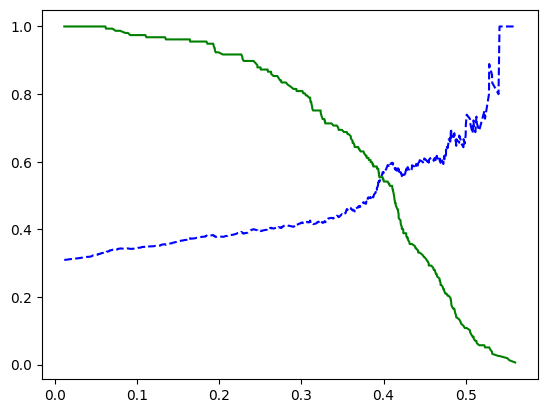

In [80]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
[...]
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [81]:
A=[]
B=[]
C=[]
for i in range(len(thresholds)):
    predicted = pd.DataFrame()
    predicted["label"] = y_pred_prob
    predicted["label"] = np.where(predicted["label"] > float(thresholds[i]), 1, 0)
    pred_valid = pd.DataFrame()
    pred_valid["label"] = y_pred_valid
    pred_valid["label"] = np.where(pred_valid["label"] > float(thresholds[i]), 1, 0)
    A.append(metrics.accuracy_score(y_train, predicted))
    B.append(metrics.accuracy_score(y_valid, pred_valid))
    C.append(thresholds[i])
acc=pd.DataFrame(C,columns=['threshold'])
acc['train_acc']=A
acc['test_acc']=B
acc.sort_values(by='test_acc',ascending=False,inplace=True)

In [82]:
acc.head()

,threshold,train_acc,test_acc
367,0.407621,0.777900,0.743590
365,0.406884,0.777023,0.743590
362,0.404524,0.777461,0.741617
370,0.411325,0.776803,0.741617
368,0.410611,0.777242,0.741617


In [83]:
cutoff=acc.iloc[0,0]
cutoff

0.40762112

In [84]:
predicted = pd.DataFrame()
predicted["label"] = y_pred_prob
predicted["label"] = np.where(predicted["label"] > float(cutoff), 1, 0)
predicted

pred_valid = pd.DataFrame()
pred_valid["label"] = y_pred_valid
pred_valid["label"] = np.where(pred_valid["label"] > float(cutoff), 1, 0)
pred_valid

predictions = pd.DataFrame()
predictions['label'] = y_pred
predictions['label'] = np.where(predictions['label'] > float(cutoff), 1, 0)
predictions

,label
0,1
1,1
2,0
3,0
4,0
...,...
559,0
560,0
561,0
562,0


In [85]:
from sklearn.metrics import roc_auc_score

In [86]:
conf_matrix = metrics.confusion_matrix(y_train, predicted)
print(conf_matrix)
acc_train = metrics.accuracy_score(y_train, predicted)
print('Accuracy: ',acc_train)
precision_train = metrics.precision_score(y_train, predicted)
print('Presicion: ',precision_train)
sensitivity_train = metrics.recall_score(y_train, predicted)
print('Recall: ',sensitivity_train)
specificity_train = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
print('Specificity: ',specificity_train)
roc_auc_score(y_train, predicted)

[[2596  472]
 [ 541  952]]
Accuracy:  0.7778995834246876
Presicion:  0.6685393258426966
Recall:  0.6376423308774279
Specificity:  0.8461538461538461


0.741898088515637

In [87]:
conf_matrix = metrics.confusion_matrix(y_valid, pred_valid)
print(conf_matrix)

acc_train = metrics.accuracy_score(y_valid, pred_valid)
print('Accuracy: ',acc_train)
precision_train = metrics.precision_score(y_valid, pred_valid)
print('Precision: ',precision_train)
sensitivity_train = metrics.recall_score(y_valid, pred_valid)
print('Recall: ',sensitivity_train)
specificity_train = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
print('Specificity: ',specificity_train)
roc_auc_score(y_valid, pred_valid)

[[294  56]
 [ 74  83]]
Accuracy:  0.7435897435897436
Precision:  0.5971223021582733
Recall:  0.5286624203821656
Specificity:  0.84


0.6843312101910828

In [88]:
from sklearn.metrics import f1_score
print(f1_score(y_train, predicted,average='macro'))
f1_score(y_valid, pred_valid,average='macro')

0.7447349818245705


0.6898761574945418